# Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



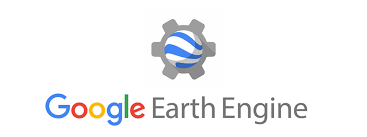

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [2]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

In [3]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download, utils
from src.data.copernicusEMS import activations

%load_ext autoreload
%autoreload 2

## Load Relevant Files

### FloodMap GeoJSON

In [4]:
floodmap_geojson = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_floodmap.geojson"
floodmap = gpd.read_file(floodmap_geojson)

In [6]:
# geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{floodmap_geojson}"



floodmap.head()

w_class source                                           geometry
0  Flooded area  flood  POLYGON ((33.46727 -24.76323, 33.46727 -24.763...
1  Flooded area  flood  POLYGON ((33.53597 -24.71282, 33.53597 -24.712...
2  Flooded area  flood  POLYGON ((33.53019 -24.71423, 33.53019 -24.714...
3  Flooded area  flood  POLYGON ((33.52663 -24.71489, 33.52663 -24.714...
4  Flooded area  flood  POLYGON ((33.53686 -24.71845, 33.53686 -24.718...

In [ ]:
# create a temperary local geojson file
temp_geojson = "geojson_show.geojson"

# select local directory
# TODO: can we download directly from GCP???
geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{temp_geojson}"

# create folder (if needed)
utils.create_folder(os.path.dirname(geojson_filepath))

# save file
floodmap.to_file(geojson_filepath, driver="GeoJSON", )

#### Meta Data FloodMap

In [5]:
meta_floodmap_filepath = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/flood_meta/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_metadata_floodmap.pickle"
metadata_floodmap = utils.read_pickle_from_gcp(meta_floodmap_filepath)

In [4]:
metadata_floodmap

{'event_id': 'EMSR495_AOI01_DEL_MONIT01_r1_v1',
 'layer_name': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1',
 'event_type': 'Coastal flood',
 'satellite_date': Timestamp('2021-01-24 16:22:28+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding_box': {'west': 33.454061058000036,
  'east': 33.705909407000036,
  'north': -24.712656954999943,
  'south': -25.18645625499994},
 'reference_system': {'code_space': 'epsg', 'code': '4326'},
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7f3d272b6cd0>,
 'observed_event_file': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR495_AOI01_DEL_MONIT01_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR495',
 'aoi_code': 'AOI01',
 'satellite_pre_event': 'Sentinel-2',
 'timestamp_pre_event': Timestamp('2020-08-28 07:26:21+0000', tz='UTC'),
 'hydrology_file_a': 'EMSR495_AOI01_DEL_MONIT01_hydrographyA_r1_v1.shp',


## Query GEE given Polygons

In [7]:
%%time
ee.Initialize()

# get area of interest polygons
bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)

# create GEE compatible polygons
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = metadata_floodmap["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

# extract event date, i.e. time boundaries
date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite_date"].timestamp())
date_end_search = date_event + timedelta(days=20)

# Load permanent water
permanent_water_img= ee_download.download_permanent_water(date_event, pol_2_clip)

CPU times: user 244 ms, sys: 11.7 ms, total: 255 ms
Wall time: 999 ms


### Plot Using Folium

In [13]:
# initialize GEEMAP
Map = geemap.Map()

# add the permanent water layer
Map.addLayer(permanent_water_img, name="permanent water")



# add layer, load geojson
Map.add_geojson(geojson_filepath, name="FloodMap", )
Map.centerObject(pol)

folium.LayerControl(collapsed=False).add_to(Map)
# Map.addLayerControl()
Map

Folder '/home/jemanjohnson34/projects/ml4floods/datasets/Copernicus_EMS_raw' Is Already There.


## Export Sentinel-2 Images to the Google Cloud Bucket

Looking at the S2 images in the map, we see that the second image (S2.1) is the less cloudy of the three images retrieved by the Google Earth Engine. We will export that to the Google bucket to further inspect it. Use <code>task</code> to monitor the status. To run this part of the code you'd need access to the ml4floods Google bucket.

In [14]:
import os

# BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

# img_export = ee.Image(imgs_list.get(1))
img_export = ee.Image(ee_download.download_permanent_water(date_event, pol_2_clip))


# img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

# TODO in the future, change to export to drive and mount the Google drive in colab!

bucket_name= "ml4cc_data_lake"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("testingcrap", "crap", "permanent_water")
desc = os.path.basename(filename) + "JRC"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=False, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
if task is not None:
    task.status()

In [24]:
task.status()

{'state': 'COMPLETED',
 'description': 'permanent_waterJRC',
 'creation_timestamp_ms': 1615232326789,
 'update_timestamp_ms': 1615232775138,
 'start_timestamp_ms': 1615232351079,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://console.developers.google.com/storage/browser/ml4cc_data_lake/testingcrap/crap/'],
 'attempt': 1,
 'id': 'ZC3Y7QNAD6WV7NW627NCLVBQ',
 'name': 'projects/earthengine-legacy/operations/ZC3Y7QNAD6WV7NW627NCLVBQ'}

## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [25]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

(5743, 4485)


(1, 5743, 4485)

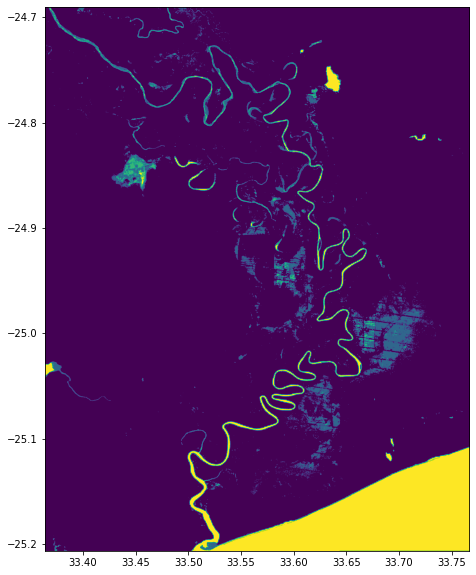

In [31]:
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10)

fig, ax = plt.subplots()
rasterioplt.show(image, transform=transform,ax=ax)
fig.savefig("./permanent_water.png")

In [34]:
np.unique(image)

array([0, 1, 2, 3], dtype=uint8)

/home/jemanjohnson34/software/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/jemanjohnson34/software/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/jemanjohnson34/software/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/jemanjohnson34/software/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


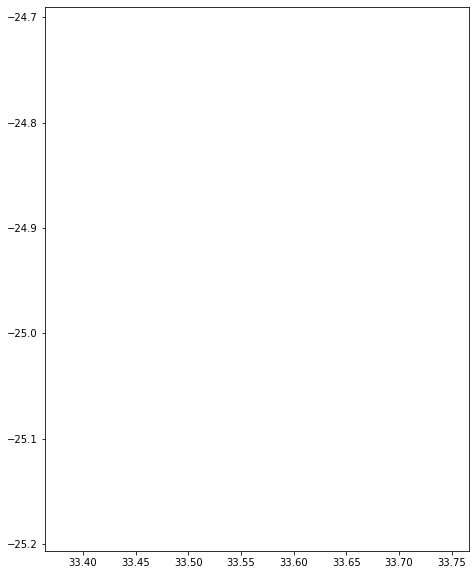

In [42]:
fig, ax = plt.subplots()

rasterioplt.show(np.ma.masked_not_equal(image, 4), transform=transform,ax=ax)
fig.savefig("./permanent_water_4.png")

(5743, 4485)


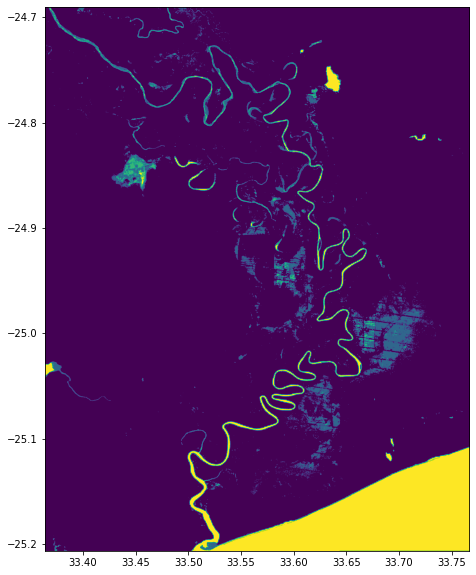

In [37]:
fig, ax = plt.subplots()

with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read(1)
    transform = src.transform
